In [1]:
import os, glob
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_pred = os.path.join(pth_data, 'modeling', 'predict')
pth_feat = os.path.join(pth_data, 'features', 'biomart')
pth_out = os.path.join(pth, 'figures', 'modeling')

In [3]:
adata = sc.read_h5ad(os.path.join(pth_pred, 'development.h5ad'))
adata

AnnData object with n_obs × n_vars = 143369 × 856
    obs: 'Stages', 'Clusters', 'Type', 'LineageAnnotations', 'celltype', 'trajectory', 't', 'training', 'validation', 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'plates', 'devtime', 'location', 'total_counts_ERCC', 'pct_counts_ERCC', 'doublet_scores', 'CytoTRACE', 'Gut_neuron', 'Sensory', 'Symp', 'enFib', 'ChC', 'Gut_glia', 'NCC', 'Mesenchyme', 'Melanocytes', 'SatGlia', 'SC', 'BCC', 'conflict', 'assignments', 'Hub', 'Hub_leiden', 'total_counts_ribo', 'pct_counts_ribo', 'T+ Sox2+', 'batch', 'percent_mito', 'n_counts', 'bh_pval', 'region', 'tissue', 'adj_stage', 'adj_sample', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'celltype_original', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.1', 'seurat_clusters', 'age', 'RNA_snn_res.0.5', 'ident', 'velocity_self_transition', 'source', 'weight_celltype', 'weight_source', 'weight', 'latent_z'
    obsm: 'X_diff', 'X_draw_gr

In [4]:
feat_fn = sorted(glob.glob(os.path.join(pth_feat, '*.csv')))
df = pd.read_csv(os.path.join(pth_data, 'summary.csv'), index_col = 0)
get_source = lambda fn: os.path.split(fn)[1].replace('.csv', '')
feat_dict = {get_source(fn) : fn for fn in feat_fn if 'union' not in fn}
for src, fn in feat_dict.items():
    print(src)
    df_feat = pd.read_csv(fn)
    g = df_feat.mmusculus.copy()
    g = g.loc[g.isin(adata.var_names)]
    for _, df_group in adata.obs.groupby('source', observed = True):
        msk = adata.obs_names.isin(df_group.index)
        adata_group = adata[msk].copy()
        sc.tl.score_genes(adata_group,
                          gene_list = g,
                          ctrl_as_ref = False,
                          score_name = src,
                          random_state = 1234)
        adata.obs.loc[msk, src] = adata_group.obs[src]

EMTHallmark
GSE136689
GSE162534
GSE201257
GSE229103
HCAEmbryonicHindlimb
rRNAModifications


In [5]:
src_train = df.loc[df.Training == True].index
msk_train = (adata.obs.training == 'True')
msk_val = (adata.obs.validation == 'True')

# training split
grp_train = adata[msk_train].obs.groupby(['source', 'celltype'], observed = True)
z_train = grp_train.latent_z.mean().loc[grp_train.size() > 160]
X_train = grp_train[src_train].mean().loc[z_train.index]

# validation split
grp_val = adata[msk_val].obs.groupby(['source', 'celltype'], observed = True)
z_val = grp_val.latent_z.mean().loc[z_train.index]
X_val = grp_val[src_train].mean().loc[z_val.index]

# linear model
reg = LinearRegression().fit(X_train, z_train)
z_pred = reg.predict(X_val)

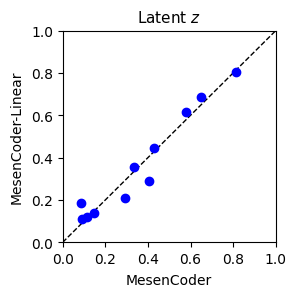

In [56]:
# plot fit
lim = (0, 1)
fig, ax = plt.subplots(1, 1, figsize = (2.75, 2.75))
ax.scatter(z_val, z_pred, c = 'b')
ax.plot(lim, lim, c = 'k', ls = '--', linewidth = 1, zorder = 0)
ax.set_xlim(lim)
ax.set_ylim(lim)

ax.set_title(r'Latent $z$', size = 11)
ax.set_xlabel('MesenCoder', size = 10, labelpad = 5)
ax.set_ylabel('MesenCoder-Linear', size = 10, labelpad = 5)

fn = os.path.join(pth_out, 'linear.pdf')
plt.savefig(fn, bbox_inches = 'tight')

In [64]:
df_out = pd.DataFrame(reg.coef_,
                      index = reg.feature_names_in_,
                      columns = ['coef'])
df_out.loc['intercept'] = reg.intercept_
df_out.to_csv(os.path.join('..', 'linear.csv'))